# **Instructions**
</div>

A new world organization has just been created. It includes all the museum management committees that have more than 2,000,000 visitors annually (in 2017).  This list is available via Wikipedia: 
https://en.wikipedia.org/wiki/List_of_most_visited_museums

\
*Goal:*

This new organization wishes to **correlate the tourist attendance at their museums with the population of the respective cities**. To achieve this, a small, common and harmonized **database must be built to be able to extract features**. 

\
*Requirements:*

This **DB must include the characteristics of museums as well as the population of the cities in which they are located**. You have been chosen to build this database. In addition, you are asked to create a **small linear regression ML algorithm** to correlate the city population and the influx of visitors.  You must use the **Wikipedia APIs to retrieve this list of museums and their characteristics**. You are free to choose the source of your choice for the population of the cities concerned.

It is required that your code is in **Python** and you have done some R&D work in a Jupyter notebook in python (which can be executed locally or via a web-hosted platform such as Colab: https://colab.research.google.com/notebooks/welcome.ipynb) using some **visualization**.

It is also required that your code can be executed in a **Docker container** (use Docker Compose if you require additional infrastructure).

\
*Evaluation:*

You will be evaluated not only on how your code works but also on the rationale for the choices you make. 

Don't hesitate to reach out with any questions or clarifications!

# **Data Engineering**
</div>

## **Imports**
</div>

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import requests
import json
import re

# Wikipedia
import wikitextparser as wtp # https://github.com/5j9/wikitextparser

from unidecode import unidecode

# String matched / distance
import jellyfish
import Levenshtein

# SQL Server
import pyodbc
import sqlalchemy
import sqlalchemy_utils

# ML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
# Credentials
server = '172.20.0.2,1433'
database='WorldMuseumsDB'
user='sa'
password='Database2023'

## **Fetch Data**
</div>


Fetch museum data using Wikipedia API 

In [ ]:
# Verify sections if needed using: prop=sections
url = "https://en.wikipedia.org/w/api.php?action=parse&prop=wikitext&page=List_of_most-visited_museums&format=json"
response = requests.get(url, verify=False)

museum_data = json.loads(response.content) # same as: museum_data = response.json() 

# # prints
# print(json.dumps(museum_data, indent=4))

Fetch population data per year from CSVs

In [28]:
df_pop_2019_raw = pd.read_csv('./raw_data/2019_worldcities_viswanathanc_kaggle.csv')
df_pop_2020_2021_raw = pd.read_csv('./raw_data/2020_2021_Populous_City_in_the_World-2020_&_2021_kaggle.csv')
df_pop_2022_raw = pd.read_csv('./raw_data/2022_worldcities_juanmah_kaggle.csv')

## **ETL (Raw Data)**
</div>

### Museum Data

Define Functions for Preprocessing

In [29]:
# Extract the table from the response
def concat_tables(parsed, verbose=False):
  """
  Concatenate wikitables

  Parameters
  ----------
  parsed : WikiText
    Parsed wikitext
  verbose : bool
    Whether to print titles and tables to standard output

  Returns
  -------
  df_museum_raw : pandas.DataFrame
    Concatenated tables as dataframe
  """
  dfs_museum = []
  
  for i, section in enumerate(parsed.sections):
    if verbose:
      print(i)
      print(str(section.title))
      print(section.tables)

    if section.tables and len(section.tables) == 1:
      df = pd.DataFrame(section.tables[0].data())
      cols = df.iloc[0].map(lambda x: x.replace(' ', '_').lower())
      df = df.rename(columns=cols).loc[1:]
      df['year'] = str(section.title)
      dfs_museum.append(df)

  df_museum_raw = pd.concat(dfs_museum, ignore_index=True)

  return df_museum_raw

# Extract text patterns from wikitext
def extract_text(s):
  """
  Extract text removing undesired characters

  Parameters
  ----------
  s : string
    A text of interest

  Returns
  -------
  Cleaned string
  """
  pattern_1 = r'\[\[(.*?)\]'
  pattern_2 = r'\|(.*?)\|'
  return ",".join(re.findall(pattern_1, s) or re.findall(pattern_2, s))

In [30]:
# Parse
parsed = wtp.parse(museum_data["parse"]["wikitext"]["*"])
df_museum_raw = concat_tables(parsed)

# Create a copy of the dataframe before preprocessing columns
df_museum = df_museum_raw.copy()

# Preprocessing
df_museum['name'] = df_museum['name'].apply(extract_text)
df_museum['location'] = df_museum['location'].apply(extract_text)

df_museum[['city','country','other']] = df_museum['location'].str.split(',',expand=True)
df_museum['country'] = np.where(df_museum['other'].notnull(), df_museum['other'], df_museum['country'])

df_museum['number_of_visitors'] = df_museum['number_of_visitors'].apply(lambda x: x.split('<ref')[0].replace(',', ''))

# Convert Data Types
df_museum = df_museum.astype(str)
df_museum[['number_of_visitors', 'year']] = df_museum[['number_of_visitors', 'year']].astype(int)

# Final Dataframe
# Select columns needed & Reset index
df_museum = df_museum[['name','city','country','number_of_visitors','year']].reset_index(drop=True)

# # displays
# display(df_museum)
# print(df_museum[df_museum['name'].notna()].count())
# df_museum.dtypes

Save to DB

In [ ]:
# Create a SQLAlchemy engine
engine = sqlalchemy.create_engine(f'mssql+pyodbc://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server')

# Create DB if not exist
if not sqlalchemy_utils.database_exists(engine.url):
    sqlalchemy_utils.create_database(engine.url)

print(sqlalchemy_utils.database_exists(engine.url))

In [ ]:

# Convert the DataFrame to a SQL table
table_name = 'FACT_MUSEUM'
df_museum.to_sql(table_name, engine, schema='dbo', if_exists='replace', index=False)

# Dispose of the engine
engine.dispose()


### Population Data

Define Functions for Preprocessing

In [ ]:
def process_population_data_2020_2021(df_pop_2020_2021_raw, years):
    """
    Preprocess df_pop_2020_2021_raw

    Parameters
    ----------
    df_pop_2020_2021_raw : pandas.DataFrame
        DataFrame containing data and structure of df_pop_2020_2021_raw

    Returns
    -------
    df_list : list
        List of cleaned dataframes
    """
    # Melt the dataframe to create separate columns for population and year
    df_pop_2020_2021 = pd.melt(df_pop_2020_2021_raw, 
                        id_vars=['Rank', 'Name', 'Country', 'Change'],
                        value_vars=['2021 Population', '2020 Population'],
                        var_name='year', value_name='population')

    # Process column names
    df_pop_2020_2021.columns = df_pop_2020_2021.columns.str.lower()
    df_pop_2020_2021 = df_pop_2020_2021.rename(columns={'name': 'city'})

    # Convert data types
    df_pop_2020_2021['year'] = df_pop_2020_2021['year'].str.replace(' Population', '').astype(int)
    df_pop_2020_2021['population'] = df_pop_2020_2021['population'].str.replace(',','').astype(int)
    df_pop_2020_2021['year'] = df_pop_2020_2021['year'].astype(int)

    df_list = []    
    for year in years:
        df_list.append(df_pop_2020_2021[df_pop_2020_2021['year'] == year])

    return df_list

def process_population_data(df_raw, year):
    """
    Preprocess population dataframes

    Parameters
    ----------
    df_raw : pandas.DataFrame
        DataFrame containing population data

    Returns
    -------
    df : pandas.DataFrame
        Cleaned df
    """
    # Create copy
    df = df_raw.copy()

    # Preprocess
    df['year'] = year
    df['population'] = df['population'].fillna(0)
    
    # Convert data types
    df['population'] = df['population'].astype(int)

    return df

In [ ]:
# Transformed dataframes per year (can be saved individually in separate db tables)
df_list = process_population_data_2020_2021(df_pop_2020_2021_raw, [2020, 2021])
df_pop_2019 = process_population_data(df_pop_2019_raw, 2019)
df_pop_2022 = process_population_data(df_pop_2022_raw, 2022)

# Final Dataframe
# Select columns needed & Reset index
df_list.extend([df_pop_2019, df_pop_2022])
df_population = pd.concat(df[['city', 'country', 'population','year']] for df in df_list).reset_index(drop=True)

# # displays
# df_pop_2020_2021[df_pop_2020_2021['city'].str.contains('ee')]
# df_pop_2019[df_pop_2019['city'].str.contains('xi')].head()
# df_population.count()
# display(df_population.head())

Save to DB

In [ ]:
# SQL Server Engine supporting pandas.DataFrame.to_sql
# engine = sqlalchemy.create_engine(f'mssql://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+13+for+SQL+Server')
engine = sqlalchemy.create_engine(f'mssql+pyodbc://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server')

table_name = 'FACT_POPULATION'
df_population.to_sql(table_name, engine, schema='dbo', if_exists='replace', index=False)

engine.dispose()

# **Data Science**
</div>

### Fetch from DB

In [ ]:
# SQL Server Connection
conn = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                      f'Server={server};'
                      f'Database={database};'
                      f'Uid={user};'
                      f'Pwd={password}') 

query_museum = 'SELECT * FROM FACT_MUSEUM'
query_pop = 'SELECT * FROM FACT_POPULATION'

df_museum_db = pd.read_sql(query_museum, conn)
df_population_db = pd.read_sql(query_pop, conn)

conn.close()

# # displays
# print(df_museum.dtypes)
# print(df_population.dtypes)
# display(df_museum.head())
# display(df_population.head())

### Data Preprocessing

#### Normalization

In [ ]:
df_museum_processed = df_museum_db.copy()
df_population_processed = df_population_db.copy()

In [ ]:
clean_text = lambda x: re.sub('[^0-9a-zA-Z]+', '', x)

df_museum_processed['city_normalized'] = df_museum_processed['city'].str.replace(' ', '').str.lower().apply(unidecode).apply(clean_text)
df_population_processed['city_normalized'] = df_population_processed['city'].str.replace(' ', '').str.lower().apply(unidecode).apply(clean_text)

#### String Similarities

Define Function

In [ ]:
# Find the closest match using Levenshtein distance and Soundex
def explore_string_similarity(cities_years_of_interest, target_df, verbose=True):
  """
  Explore string similaity result and print to standar output as needed

  Parameters
  ----------
  cities_years_of_interest : list of tuples
      List containing (city, year) subject to exploration 
  target_df : pandas.DataFrame
      DataFrame containing population data

  Returns
  -------
  None
  """
  for city, year in cities_years_of_interest:
    cities = list(target_df[target_df['year'] == year]['city_normalized'])
    
    prefix_matches = target_df[(target_df['year'] == year) & (target_df['city_normalized'].apply(lambda x: x.startswith(city)))]['city_normalized'].tolist()
    best_match_s = max(cities, key=lambda x: jellyfish.soundex(x) == jellyfish.soundex(city))
    best_match_l = min(cities, key=lambda x: Levenshtein.distance(x, city))
  
    # Print the matches
    if verbose:
      print(city)
      print("prefix matches: " + str(prefix_matches))
      print("best_match sound:" + best_match_s)
      print("best_match letter:" + best_match_l)
      print()

In [ ]:
# Investigate dissimilarities
df_test = pd.merge(df_museum_processed, df_population_processed,  how='left', 
                     left_on = [df_museum_processed['city_normalized'],'year'], 
                     right_on = [df_population_processed['city_normalized'],'year'])

df_investigate = df_test[df_test['population'].isna()]
display(df_investigate)

cities_years_of_interest = list(zip(df_investigate['city_normalized_x'], df_investigate['year']))
explore_string_similarity(cities_years_of_interest, df_population_processed, verbose=True)

,key_0,name,city_x,country_x,number_of_visitors,year,city_normalized_x,city_y,country_y,population,city_normalized_y
94,vaticancity,Vatican Museums,Vatican City,None,1612530,2021,vaticancity,NaN,NaN,NaN,NaN
98,taichung,National Museum of Natural Science,Taichung,Taiwan,1566000,2021,taichung,NaN,NaN,NaN,NaN
101,taipei,National Taiwan Science Education Center,Taipei,Taiwan,1158000,2021,taipei,NaN,NaN,NaN,NaN
113,edinburgh,National Museum of Scotland,Edinburgh,United Kingdom,660741,2021,edinburgh,NaN,NaN,NaN,NaN
116,munchen,Deutsches Museum,München,Germany,517000,2021,munchen,NaN,NaN,NaN,NaN
118,taipei,"National Palace Museum,Southern Branch of the ...",Taipei,Taiwan,416436,2021,taipei,NaN,NaN,NaN,NaN
124,xian,Shaanxi History Museum,Xi'an,None,1000000,2020,xian,NaN,NaN,NaN,NaN


vaticancity
prefix matches: []
best_match sound:tokyo
best_match letter:mexicocity

taichung
prefix matches: []
best_match sound:taizhong
best_match letter:taizhong

taipei
prefix matches: []
best_match sound:taibei
best_match letter:taibei

edinburgh
prefix matches: []
best_match sound:tokyo
best_match letter:hamburg

munchen
prefix matches: []
best_match sound:maanshan
best_match letter:yuncheng

taipei
prefix matches: []
best_match sound:taibei
best_match letter:taibei

xian
prefix matches: ['xianshaanxi', 'xiangyang', 'xiangtanhunan', 'xianyangshaanxi', 'xiantao']
best_match sound:xinyu
best_match letter:xiamen



In [ ]:
## Handle string dissmilarities
column = 'city_normalized'

df_population_clean = df_population_processed.copy()
df_museum_clean = df_museum_processed.copy()

df_population_clean.loc[df_population_clean[column] == 'taizhong', column] = 'taichung'
df_population_clean.loc[df_population_clean[column] == 'taibei', column] = 'taipei'
df_population_clean.loc[df_population_clean[column] == 'xianshaanxi', column] = 'xian'

#### Merge Dataframes

In [ ]:
## Merge the 2 dataframes 
df_merged = pd.merge(df_museum_clean, df_population_clean,  how='left', 
                     left_on = [df_museum_clean['city_normalized'],'year'], 
                     right_on = [df_population_clean['city_normalized'],'year'])

df_merged['population'] = df_merged['population'].fillna(0)
df_merged = df_merged.loc[df_merged.groupby(['name', 'city_x','year'])['population'].idxmax()].reset_index(drop=True)

display(df_merged[df_merged['population'] == 0])

,key_0,name,city_x,country_x,number_of_visitors,year,city_normalized_x,city_y,country_y,population,city_normalized_y
10,munchen,Deutsches Museum,München,Germany,517000,2021,munchen,NaN,NaN,0.0,NaN
47,edinburgh,National Museum of Scotland,Edinburgh,United Kingdom,660741,2021,edinburgh,NaN,NaN,0.0,NaN
70,vaticancity,Vatican Museums,Vatican City,None,1612530,2021,vaticancity,NaN,NaN,0.0,NaN


In [ ]:
## Post-merge processing: Add Missing Info after merge (can find batch process if big data size, it would be overkill in this case)

# Population Source: https://www.nrscotland.gov.uk/files/statistics/council-area-data-sheets/city-of-edinburgh-council-profile.html
df_merged.loc[(df_merged['city_x'] == 'Edinburgh') & (df_merged['year'] == 2021) , 'population'] = 526470

# Population Source: https://www.macrotrends.net/cities/204371/munich/population
df_merged.loc[(df_merged['city_x'] == 'München') & (df_merged['year'] == 2021), 'population'] = 1553000

# Population Source: https://worldpopulationreview.com/countries/vatican-city-population
df_merged.loc[(df_merged['city_x'] == 'Vatican City') & (df_merged['year'] == 2021), 'population'] = 511

df_merged['country_x'] = np.where((df_merged['country_y'].notna()), df_merged['country_y'], df_merged['country_x'])
df_merged.loc[df_merged['city_x'] == 'Vatican City', 'country_x'] = 'Vatican City'

# # displays
# display(df_merged[df_merged['country_x'] == 'None'])
# display(df_merged[df_merged.isna().any(axis=1)])
# display(df_merged.sort_values('city_x', ascending=True))
# display(df_merged[df_merged['population'] == 0])
# print(df_merged.count())

#### Final Data (merged & cleaned)

In [ ]:
# Final Dataframe
# Select columns needed & Reset index
df_final = df_merged.rename(columns=lambda x: x.rstrip('_x'))
df_final = df_final[['name','number_of_visitors','year','population','city_normalized','city', 'country']].reset_index(drop=True)

display(df_final.head())

,name,number_of_visitors,year,population,city_normalized,city,country
0,British Museum,1327120,2021,9425622.0,london,London,United Kingdom
1,California Science Center,271000,2020,3981560.0,losangeles,Los Angeles,United States
2,Centre Pompidou,1500000,2021,11078546.0,paris,Paris,France
3,Centre Pompidou,3000000,2022,11027000.0,paris,Paris,France
4,Centro Cultural Banco do Brasil,790357,2020,13458075.0,riodejaneiro,Rio de Janeiro,Brazil


Save Final Dataframe as CSV

In [ ]:
try:
    df_final.to_csv('./clean_data/clean_museum_population.csv', sep=',', index=False)
except Exception as e:
    print(f'Error writing file: {e}')

## **Linear Regression**
</div>

In [ ]:
def eval_model(regression_model, y, y_pred):
    """
    Evaluate linear regression model

    Parameters
    ----------
    regression_model : LinearRegression
        LinearRegression model used
    y : array
        Target values
    y_pred : array
        Predicted values

    Returns
    -------
    None
    """
    rmse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print('Slope:' ,regression_model.coef_)
    print('Intercept:', regression_model.intercept_)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)

def plot_values(X, y, y_pred, X_label, y_label, target_color, pred_color):
    """
    Plot model results

    Parameters
    ----------
    X : array
        Input values
    y : array
        Target values
    y_pred : array
        Predicted values
    X_label : string
        x-axis title
    y_label : string
        y-axis title
    target_color : string
        Scatter plot color
    pred_color : string
        Line plot cplor

    Returns
    -------
    None
    """
    # data points
    plt.scatter(X, y, color=target_color, s=10)
    plt.xlabel(X_label)
    plt.ylabel(y_label)

    # predicted values
    plt.plot(X, y_pred, color=pred_color)
    plt.show()


In [ ]:
# Sckit-learn implementation

# Converting each dataframe into a numpy array 
X = np.array(df_final['population']).reshape(-1, 1)
y = np.array(df_final['number_of_visitors']).reshape(-1, 1)

# Future Improvement: Pipeline

####################################### Iter 1 #############################################
# Model initialization
regr_1 = LinearRegression()

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Fit the data(train the model)
regr_1.fit(X_train, y_train)
# Predict
y_pred = regr_1.predict(X_test)


####################################### Iter 2 #############################################
# Model initialization
regr_2 = LinearRegression()

# Fit the data(train the model)
regr_2.fit(X, y)
# Predict
y_predicted = regr_2.predict(X)

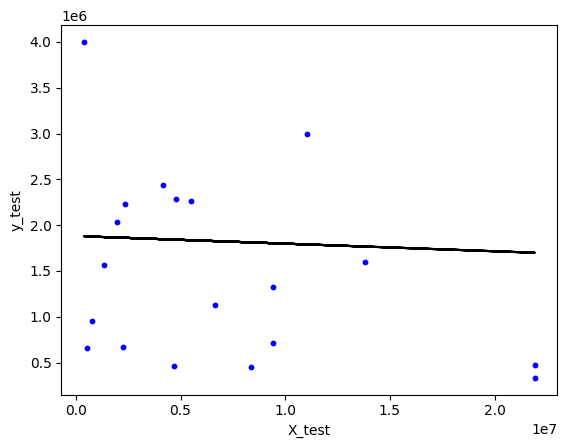

Slope: [[-0.00830857]]
Intercept: [1880969.10346332]
Root mean squared error:  1039620174654.3783
R2 score:  -0.06960032672584049


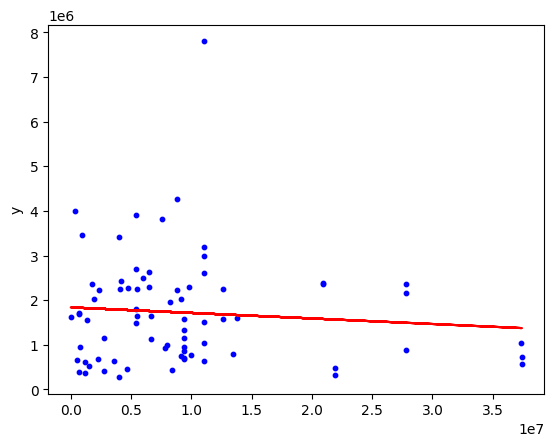

Slope: [[-0.01238611]]
Intercept: [1837429.7442819]
Root mean squared error:  1456372076008.6213
R2 score:  0.007724408201599142


In [ ]:
plot_values(X_test, y_test, y_pred, X_label='X_test', y_label='y_test', target_color='b', pred_color='k')
eval_model(regr_1, y_test, y_pred)

plot_values(X, y, y_predicted, X_label='', y_label='y', target_color='b', pred_color='r')
eval_model(regr_2, y, y_predicted)

# Data Visualization #

In [ ]:
# Future Improvement: Class
def plot_visitors_by_city(dataframe):
    """
    Plots a bar chart showing the total number of visitors to museums by city.

    Args:
    dataframe (pandas.DataFrame): DataFrame containing the data with columns 'city' and 'number_of_visitors'

    Returns:
    None
    """
    # Group the data by city and calculate the total number of visitors
    visitors_by_city = dataframe.groupby(['city']).sum().reset_index()

    # Sort the data by the number of visitors in ascending order
    visitors_by_city = visitors_by_city.sort_values('number_of_visitors')

    # Plot the data as a bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    visitors_by_city.plot(kind='bar', x='city', y='number_of_visitors', ax=ax)

    # Set the tick formatter to show values in thousands
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

    # Set the axis labels and title
    ax.set_xlabel('City')
    ax.set_ylabel('Number of visitors')
    ax.set_title('Number of visitors to museums by city')

    # Display the plot
    plt.show()

In [ ]:
def plot_visitors_and_population_by_city_year(df, population=False):
    
    # Group the data by year and city
    grouped = df.groupby(['year', 'city']).sum()

    # Get a list of unique years
    years = df['year'].unique()

    # Create a bar chart for each year
    if population:
        grouped = grouped.sort_values(['year','population'])
        for year in years:
            data = grouped.loc[year]
            ax = data[['number_of_visitors', 'population']].plot(kind='bar', color=['blue', 'red'])
            ax.set_title(f'Visitors and population by city in {year}')
            ax.set_xlabel('City')
            ax.set_ylabel('Number of visitors / Population')
            plt.show()
    
    grouped = grouped.sort_values(['year','number_of_visitors'])
    for year in years:
        data = grouped.loc[year]
        data.plot(kind='bar', y='number_of_visitors')
        plt.title(f'Visitors by city in {year}')
        plt.xlabel('City')
        plt.ylabel('Number of visitors')
        plt.show()

C:\Users\sarzhou\AppData\Local\Temp\ipykernel_62168\4084076003.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  visitors_by_city = dataframe.groupby(['city']).sum().reset_index()


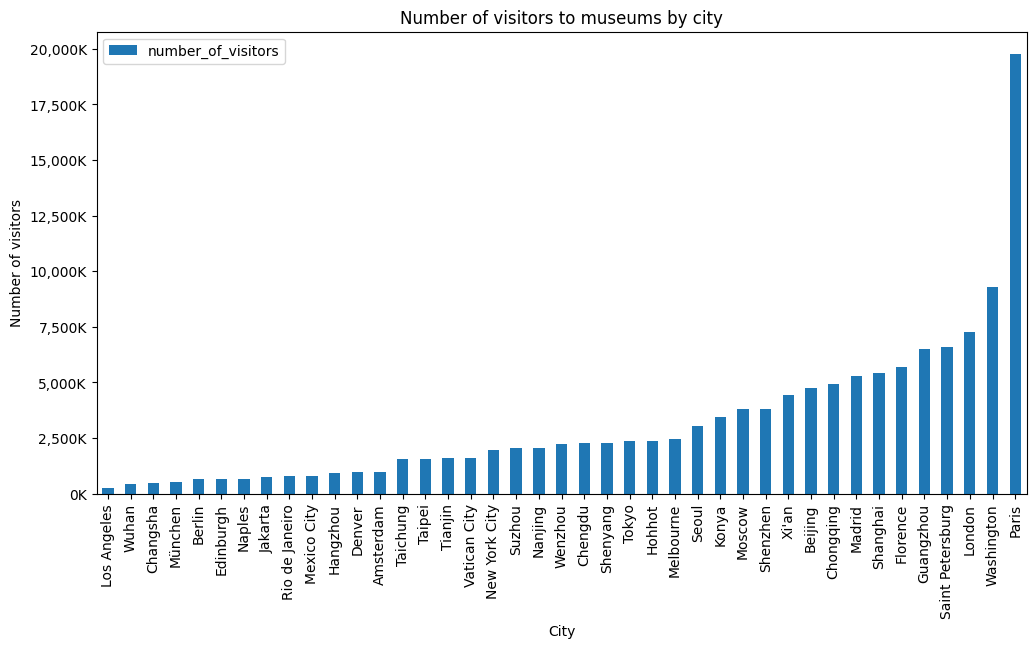

In [ ]:
plot_visitors_by_city(df_final)

C:\Users\sarzhou\AppData\Local\Temp\ipykernel_62168\2614246470.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df.groupby(['year', 'city']).sum()


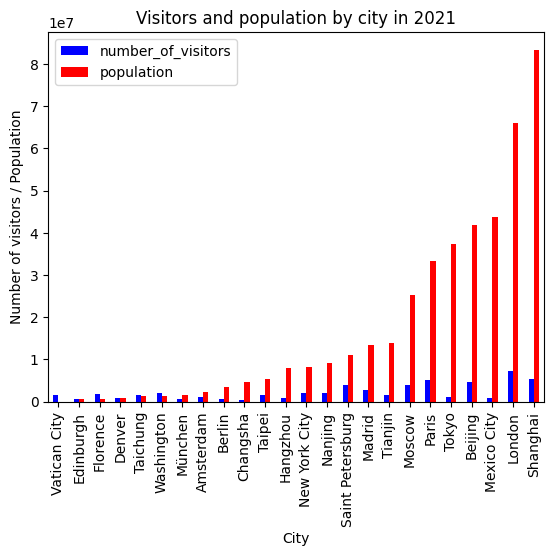

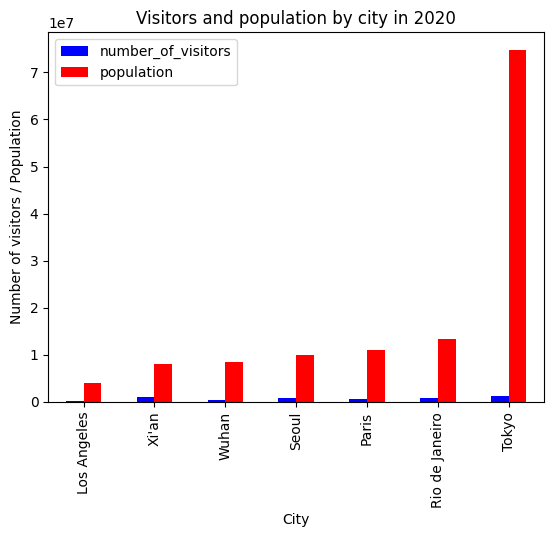

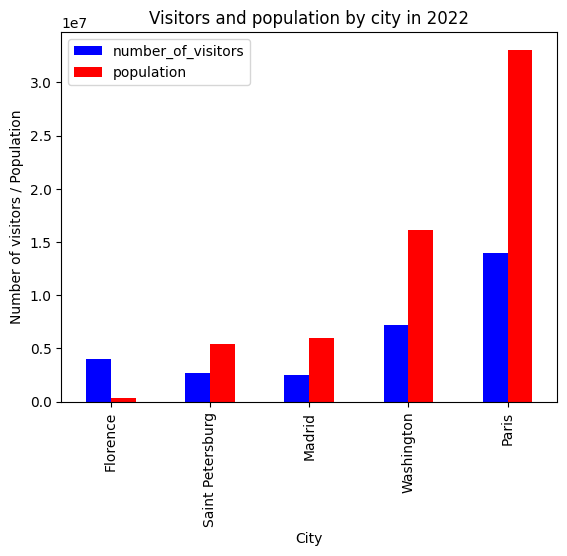

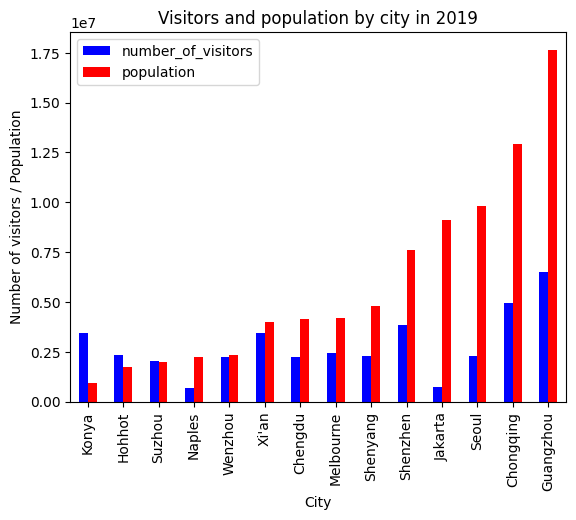

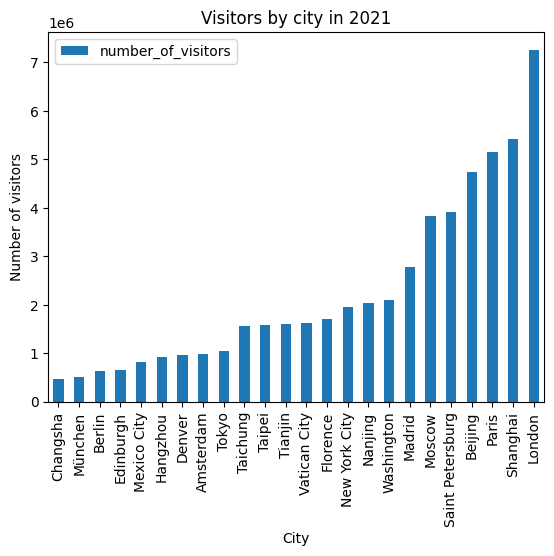

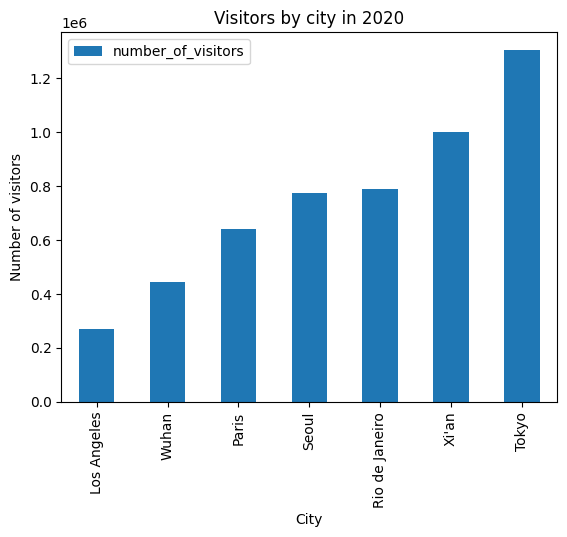

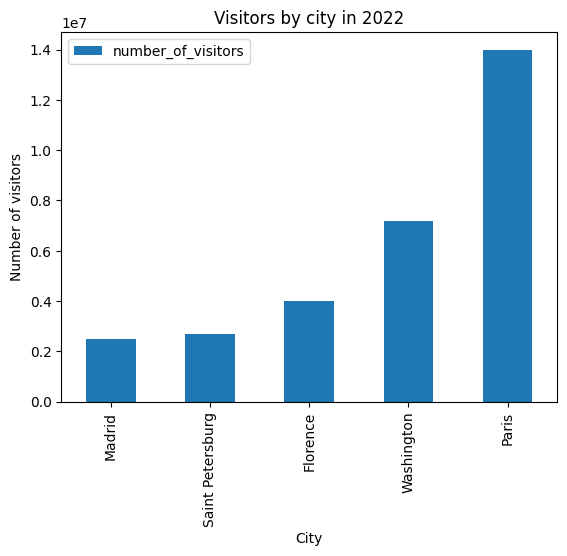

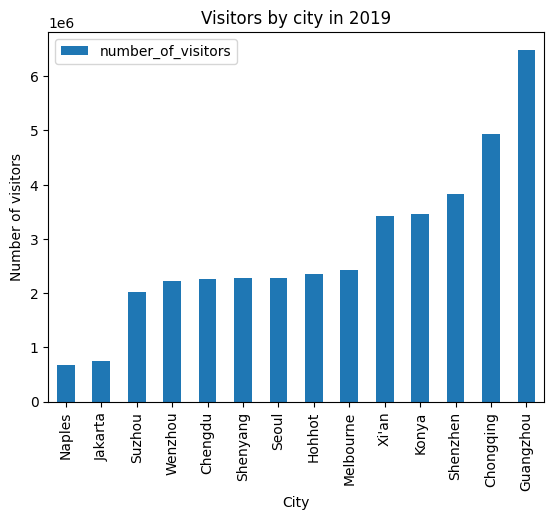

In [ ]:
plot_visitors_and_population_by_city_year(df_final, True)